In [1]:

import tensorflow as tf
from Compute_Jacobian import jacobian # Please download 'Compute_Jacobian.py' in the repository 
import numpy as np
import timeit
from scipy.interpolate import griddata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import layers, activations

# tf.enable_eager_execution()
os.environ["KMP_WARNINGS"] = "FALSE" 
import timeit

import sys

import scipy
import scipy.io
import time
from pyDOE import lhs


In [2]:




class PINN:
    # Initialize the class
    def __init__(self, layers, sess):
        # Normalization 
     

        self.sess = sess
        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        

        self.lam_f_val =  tf.Variable([1.0], dtype=tf.float32)
        self.lam_ics_val =  tf.Variable([1.0], dtype=tf.float32)
      
        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))

        # Define placeholders and computational graph

        self.t_pred_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_pred_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_pred_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.v_bc_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.p_bc_tf = tf.placeholder(tf.float32, shape=(None, 1))



        self.t_f_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_f_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_f_tf = tf.placeholder(tf.float32, shape=(None, 1))
        

        # Evaluate predictions

        self.u_pred, self.v_pred, self.p_pred = self.net_u(self.t_pred_tf, self.x_pred_tf , self.y_pred_tf)


        self.u_bc_pred, self.v_bc_pred, _ = self.net_u(self.t_bc_tf, self.x_bc_tf , self.y_bc_tf)

        self.f_u_pred  , self.f_v_pred  , self.div_pred = self.net_r(self.t_f_tf, self.x_f_tf, self.y_f_tf)
        

        self.loss_ics_u =  self.lam_ics_val * (tf.reduce_sum(tf.square(self.u_bc_pred - self.u_bc_tf)) + tf.reduce_sum(tf.square(self.v_bc_pred - self.v_bc_tf)))

        self.loss_f = self.lam_f_val * (tf.reduce_sum(tf.square(self.f_u_pred)) + tf.reduce_sum(tf.square(self.f_v_pred)) + tf.reduce_sum(tf.square(self.div_pred)))


        # Total loss
        self.loss = self.loss_ics_u + self.loss_f # + self.lam_ut_tf * self.loss_ics_u_t 


        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 0.005
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,  1000, 0.99, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step , var_list= self.weights + self.biases)

    
        
        self.optimizer_weights = tf.train.AdamOptimizer(self.learning_rate).minimize(-self.loss_f , global_step=self.global_step , var_list= [self.lam_f_val])
        self.optimizer_u = tf.train.AdamOptimizer(self.learning_rate).minimize(-self.loss_ics_u , global_step=self.global_step , var_list= [self.lam_ics_val])

       
         # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,  dtype=tf.float32)

        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H, layers, weights, biases):
        num_layers = len(layers)
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    # Forward pass for u
    def net_u(self, t, x , y):
        output = self.forward_pass(tf.concat([t, x , y], 1),  self.layers, self.weights, self.biases)
        u = output[:,0:1]
        v = output[:,1:2]
        p = output[:,2:3]
        return u , v , p


    # Forward pass for the residual
    def net_r(self, t, x , y):
        u , v  , p = self.net_u(t, x , y)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]

        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]

        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        div = u_x + v_y
        c1 = tf.constant(0.01, dtype=tf.float32)
        f_u = u_t + u*u_x + v*u_y + p_x -c1*(u_xx + u_yy) - ((np.pi)*tf.cos(np.pi*x)*tf.cos(np.pi*y)*tf.sin(t) - tf.cos(np.pi*y)*(tf.sin(np.pi*x))**2*tf.sin(np.pi*y)*tf.cos(t) + \
        c1*(2*(np.pi)**2*(tf.cos(np.pi*x))**2*tf.cos(np.pi*y)*tf.sin(np.pi*y)*tf.sin(t) - 6*(np.pi)**2*tf.cos(np.pi*y)*(tf.sin(np.pi*x))**2*tf.sin(np.pi*y)*tf.sin(t)) - \
        tf.cos(np.pi*x)*tf.sin(np.pi*x)*(tf.sin(np.pi*y))**2*tf.sin(t)*(np.pi*(tf.cos(np.pi*y))**2*(tf.sin(np.pi*x))**2*tf.sin(t) - np.pi*(tf.sin(np.pi*x))**2*(tf.sin(np.pi*y))**2*tf.sin(t)) +\
        2*np.pi*tf.cos(np.pi*x)*(tf.cos(np.pi*y))**2*(tf.sin(np.pi*x))**3*(tf.sin(np.pi*y))**2*(tf.sin(t))**2)

        f_v = v_t + u*v_x + v*v_y + p_y - c1*(v_xx + v_yy) - (tf.cos(np.pi*x)*tf.sin(np.pi*x)*(tf.sin(np.pi*y))**2*tf.cos(t) - np.pi*tf.sin(np.pi*x)*tf.sin(np.pi*y)*tf.sin(t) - \
        c1*(2*(np.pi)**2*tf.cos(np.pi*x)*(tf.cos(np.pi*y))**2*tf.sin(np.pi*x)*tf.sin(t) - 6*(np.pi)**2*tf.cos(np.pi*x)*tf.sin(np.pi*x)*(tf.sin(np.pi*y))**2*tf.sin(t)) -\
        tf.cos(np.pi*y)*(tf.sin(np.pi*x))**2*tf.sin(np.pi*y)*tf.sin(t)*(np.pi*(tf.cos(np.pi*x))**2*(tf.sin(np.pi*y))**2*tf.sin(t) -\
        np.pi*(tf.sin(np.pi*x))**2*(tf.sin(np.pi*y))**2*tf.sin(t)) + 2*np.pi*(tf.cos(np.pi*x))**2*tf.cos(np.pi*y)*(tf.sin(np.pi*x))**2*(tf.sin(np.pi*y))**3*(tf.sin(t))**2)

        return f_u, f_v, div


    def trainmb(self, X_f , X_u_train , u_train,  v_train , nIter=10000, batch_size=128):

        start_time = timeit.default_timer()
        
        for it in range(1 , nIter):

            # Fetch residual mini-batch
            # Define a dictionary for associating placeholders with data
            tf_dict = {
                self.x_f_tf: X_f[:, 0:1],
                self.y_f_tf: X_f[:, 1:2],
                self.t_f_tf: X_f[:, 2:3] , 
                self.t_bc_tf: X_u_train[:, 2:3],
                self.x_bc_tf: X_u_train[:, 0:1],
                self.y_bc_tf: X_u_train[:, 1:2], 
                self.u_bc_tf: u_train[:, 0:1],
                self.v_bc_tf: v_train[:, 0:1], 
                       }

            # Run the Tensorflow session to minimize the loss
            self.sess.run([ self.train_op], tf_dict)

            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time

                loss , loss_f , loss_ics_u = self.sess.run( [self.loss  , self.loss_f ,self.loss_ics_u ] , tf_dict)

                print('It: %d, Loss: %.3e,  loss_f: %.3e,  loss_ics_u: %.3e ,  Time: %.2f' %(it, loss, loss_f , loss_ics_u , elapsed))
                
          
                if it % 100== 0: 
                        self.sess.run([ self.optimizer_u], tf_dict)
                        self.sess.run([ self.optimizer_weights], tf_dict)
                        lam_bc1_val , lam_ics_val = self.sess.run( [self.lam_ics_val , self.lam_f_val ],tf_dict)

                        print("lam_bc1_val : %.3e "%(lam_bc1_val[0]))
                        print("lam_ics_val : %.3e "%(lam_ics_val[0]))

                sys.stdout.flush()
                start_time = timeit.default_timer()

####################################################################################################

    # Evaluates predictions at test points
    def predict_u(self, X_star):
        # X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_pred_tf: X_star[:, 0:1], self.x_pred_tf: X_star[:, 1:2] , self.y_pred_tf: X_star[:, 2:3]}
        u_star , v_star , p_star = self.sess.run([self.u_pred, self.v_pred , self.p_pred] , tf_dict)
        return u_star , v_star , p_star


    
   ###############################################################################################################################################
   # 
   # ###############################################################################################################################################
   # 
   # ###############################################################################################################################################
   # 
   #  




In [83]:
32 *32 *20

20480

In [90]:

N_f = 10000
Nu1 = 200

weight_ub = tf.Variable([1.0], dtype=tf.float32)
weight_fu = tf.Variable([1.0], dtype=tf.float32)

x1 = (np.linspace(0, 1, 32)).flatten()[:, None]
y1 = (np.linspace(0, 1, 32)).flatten()[:, None]
t1 = (np.linspace(0, 1, 20)).flatten()[:, None]

ttt1, ttt0 = np.meshgrid(x1, y1)

tt1 = np.concatenate(([ttt1.flatten()[:, None], ttt0.flatten()[:, None], np.zeros((x1.shape[0] * y1.shape[0], 1))]), axis=1)
x_1t = np.array([tt1[:, 0]]).T
y_1t = np.array([tt1[:, 1]]).T
t_1t = np.array([tt1[:, 2]]).T
ut1 = -np.sin(t_1t) * np.sin(np.pi * x_1t) * np.sin(np.pi * x_1t) * np.sin(np.pi * y_1t) * np.cos(np.pi * y_1t)
vt1 = np.sin(t_1t) * np.sin(np.pi * x_1t) * np.cos(np.pi * x_1t) * np.sin(np.pi * y_1t) * np.sin(np.pi * y_1t)

yyy1, yyy0 = np.meshgrid(x1, t1)

yy1 = np.concatenate(
    ([yyy1.flatten()[:, None], np.min(y1) * np.ones((x1.shape[0] * t1.shape[0], 1)), yyy0.flatten()[:, None]]), axis=1)
x_1y = np.array([yy1[:, 0]]).T
y_1y = np.array([yy1[:, 1]]).T
t_1y = np.array([yy1[:, 2]]).T
uy1 = -np.sin(t_1y) * np.sin(np.pi * x_1y) * np.sin(np.pi * x_1y) * np.sin(np.pi * y_1y) * np.cos(np.pi * y_1y)
vy1 = np.sin(t_1y) * np.sin(np.pi * x_1y) * np.cos(np.pi * x_1y) * np.sin(np.pi * y_1y) * np.sin(np.pi * y_1y)

yy2 = np.concatenate(
    ([yyy1.flatten()[:, None], np.max(y1) * np.ones((x1.shape[0] * t1.shape[0], 1)), yyy0.flatten()[:, None]]), axis=1)
x_2y = np.array([yy2[:, 0]]).T
y_2y = np.array([yy2[:, 1]]).T
t_2y = np.array([yy2[:, 2]]).T
uy2 = -np.sin(t_2y) * np.sin(np.pi * x_2y) * np.sin(np.pi * x_2y) * np.sin(np.pi * y_2y) * np.cos(np.pi * y_2y)
vy2 = np.sin(t_2y) * np.sin(np.pi * x_2y) * np.cos(np.pi * x_2y) * np.sin(np.pi * y_2y) * np.sin(np.pi * y_2y)


xxx1, xxx0 = np.meshgrid(y1, t1)

xx1 = np.concatenate(
    ([np.min(x1) * np.ones((y1.shape[0] * t1.shape[0], 1)), xxx1.flatten()[:, None], xxx0.flatten()[:, None]]), axis=1)
x_1x = np.array([xx1[:, 0]]).T
y_1x = np.array([xx1[:, 1]]).T
t_1x = np.array([xx1[:, 2]]).T
ux1 = -np.sin(t_1x) * np.sin(np.pi * x_1x) * np.sin(np.pi * x_1x) * np.sin(np.pi * y_1x) * np.cos(np.pi * y_1x)
vx1 = np.sin(t_1x) * np.sin(np.pi * x_1x) * np.cos(np.pi * x_1x) * np.sin(np.pi * y_1x) * np.sin(np.pi * y_1x)

xx2 = np.concatenate(
    ([np.max(x1) * np.ones((y1.shape[0] * t1.shape[0], 1)), xxx1.flatten()[:, None], xxx0.flatten()[:, None]]), axis=1)
x_2x = np.array([xx2[:, 0]]).T
y_2x = np.array([xx2[:, 1]]).T
t_2x = np.array([xx2[:, 2]]).T
ux2 = -np.sin(t_2x) * np.sin(np.pi * x_2x) * np.sin(np.pi * x_2x) * np.sin(np.pi * y_2x) * np.cos(np.pi * y_2x)
vx2 = np.sin(t_2x) * np.sin(np.pi * x_2x) * np.cos(np.pi * x_2x) * np.sin(np.pi * y_2x) * np.sin(np.pi * y_2x)

X_u1 = np.vstack([tt1, yy1, yy2, xx1, xx2])
u1 = np.vstack([ut1, uy1, uy2, ux1, ux2])
v1 = np.vstack([vt1, vy1, vy2, vx1, vx2])

idx_1 = np.random.choice(X_u1.shape[0], Nu1, replace=False)
X_u_train = X_u1[idx_1, :]
u_train = u1[idx_1, :]
v_train = v1[idx_1, :]

X1, Y1, T1 = np.meshgrid(x1, y1, t1)
#    Exact = np.sin(np.pi*X)*np.sin(np.pi*T)*np.sin(np.pi*Z)  #100*100*100
U_exact1 = -np.sin(T1) * np.sin(np.pi * X1) * np.sin(np.pi * X1) * np.sin(np.pi * Y1) * np.cos(np.pi * Y1)
V_exact1 = np.sin(T1) * np.sin(np.pi * X1) * np.cos(np.pi * X1) * np.sin(np.pi * Y1) * np.sin(np.pi * Y1)
P_exact1 = np.sin(T1) * np.sin(np.pi * X1) * np.cos(np.pi * Y1)

X_star1 = np.hstack((X1.flatten()[:, None], Y1.flatten()[:, None], T1.flatten()[:, None]))
x_star1 = np.array([X_star1[:, 0]]).T
y_star1 = np.array([X_star1[:, 1]]).T
t_star1 = np.array([X_star1[:, 2]]).T

u_exact1 = -np.sin(t_star1) * np.sin(np.pi * x_star1) * np.sin(np.pi * x_star1) * np.sin(np.pi * y_star1) * np.cos(np.pi * y_star1)
v_exact1 = np.sin(t_star1) * np.sin(np.pi * x_star1) * np.cos(np.pi * x_star1) * np.sin(np.pi * y_star1) * np.sin(np.pi * y_star1)
p_exact1 = np.sin(t_star1) * np.sin(np.pi * x_star1) * np.cos(np.pi * y_star1)

lb1 = X_star1.min(0)
ub1 = X_star1.max(0)

X_f_train11 = lb1 + (ub1 - lb1) * lhs(3, N_f)
X_f = np.vstack((X_f_train11, X_u_train))

xb = tf.cast(X_u_train[:, 0:1], dtype=tf.float32)
yb = tf.cast(X_u_train[:, 1:2], dtype=tf.float32)
tb = tf.cast(X_u_train[:, 2:3], dtype=tf.float32)
ub = tf.cast(u_train[:, 0:1], dtype=tf.float32)
vb = tf.cast(v_train[:, 0:1], dtype=tf.float32)


lb = X_star1.min(0)
rb = X_star1.max(0)

# x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=tf.float32)
# y_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=tf.float32)
# t_f = tf.convert_to_tensor(X_f[:, 2:3], dtype=tf.float32)

In [4]:
#test_method(mtd , layers,  X_u, Y_u, X_r, Y_r ,  X_star , u_star , r_star  , nIter ,batch_size , bcbatch_size , ubatch_size)
def test_method(method , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size ):

    tf.reset_default_graph()
    gpu_options = tf.GPUOptions(visible_device_list="0")
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:
        # sess.run(init)

        model = PINN(layers, operator, ics_sampler, bcs_sampler, res_sampler, c, kernel_size , sess)
        # Train model
        start_time = time.time()

        if method =="full_batch":
            print("full_batch method is used")
            model.train(nIter  , bcbatch_size , ubatch_size  )
        elif method =="mini_batch":
            print("mini_batch method is used")
            model.trainmb(nIter, mbbatch_size)
        else:
            print("unknown method!")
        elapsed = time.time() - start_time

        # Predictions
        u_pred = model.predict_u(X_star)
        # Predictions

        sess.close()   

    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

    print('elapsed: {:.2e}'.format(elapsed))

    print('Relative L2 error_u: {:.2e}'.format(error_u))


    return [elapsed, error_u  , model]

###############################################################################################################################################



In [44]:
t_star1.shape

(20480, 1)

In [21]:
X_star.shape

(3, 20480)

In [5]:




nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M5'
layers = [3, 20, 20, 20, 20, 20, 20, 20, 3]


X_star = np.array([t_star1.flatten() , x_star1.flatten() , y_star1.flatten()]).T

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        # [elapsed, error_u , model] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_star , r_star , nIter ,mbbatch_size , bcbatch_size , ubatch_size )
        tf.reset_default_graph()
        gpu_options = tf.GPUOptions(visible_device_list="0")
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=False, log_device_placement=False)) as sess:
            # sess.run(init)

            model = PINN(layers , sess)
            # Train model
            start_time = time.time()

            if mtd =="full_batch":
                print("full_batch method is used")
                model.train(nIter  , bcbatch_size , ubatch_size  )
            elif mtd =="mini_batch":
                print("mini_batch method is used")
                model.trainmb(X_f,X_u_train, u_train, v_train ,  nIter=10000, batch_size=128)
            else:
                print("unknown method!")
            elapsed = time.time() - start_time

            # Predictions
            v_exact1 , v_pred , p_pred = model.predict_u(X_star)
            # Predictions

            sess.close()   

            error_u = np.linalg.norm(u_exact1 - v_exact1, 2) / np.linalg.norm(u_exact1, 2)
            error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
            error_p = np.linalg.norm(p_exact1 - p_pred, 2) / np.linalg.norm(p_exact1, 2)

            print('elapsed: {:.2e}'.format(elapsed))

            print('Relative L2 error_u: {:.2e}'.format(error_u))
            print('Relative L2 error_v: {:.2e}'.format(error_v))
            print('Relative L2 error_p: {:.2e}'.format(error_p))


        print('elapsed: {:.2e}'.format(elapsed))
        print('Relative L2 error_u: {:.2e}'.format(error_u))

        time_list.append(elapsed)
        error_u_list.append(error_u)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )

    result_dict[mtd] = [time_list ,error_u_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat("./1DWave_database/"+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_"+str(iterations)+".mat" , result_dict)

###############################################################################################################################################


Method:  mini_batch
Epoch:  1







2023-11-30 03:01:16.570945: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 03:01:16.596796: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2023-11-30 03:01:16.597372: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f0f1ae9250 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-30 03:01:16.597384: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-30 03:01:16.600809: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.





mini_batch method is used
It: 100, Loss: 1.209e+03,  loss_f: 1.168e+03,  loss_ics_u: 4.090e+01 ,  Time: 14.88
lam_bc1_val : 1.005e+00 
lam_ics_val : 1.005e+00 
It: 200, Loss: 4.449e+02,  loss_f: 4.030e+02,  loss_ics_u: 4.195e+01 ,  Time: 8.82
lam_bc1_val : 1.010e+00 
lam_ics_val : 1.009e+00 
It: 300, Loss: 2.765e+02,  loss_f: 2.394e+02,  loss_ics_u: 3.710e+01 ,  Time: 8.94
lam_bc1_val : 1.015e+00 
lam_ics_val : 1.013e+00 
It: 400, Loss: 1.587e+02,  loss_f: 1.279e+02,  loss_ics_u: 3.086e+01 ,  Time: 9.15
lam_bc1_val : 1.020e+00 
lam_ics_val : 1.017e+00 
It: 500, Loss: 4.916e+02,  loss_f: 4.708e+02,  loss_ics_u: 2.084e+01 ,  Time: 9.41
lam_bc1_val : 1.025e+00 
lam_ics_val : 1.020e+00 
It: 600, Loss: 9.559e+01,  loss_f: 7.858e+01,  loss_ics_u: 1.701e+01 ,  Time: 9.22
lam_bc1_val : 1.029e+00 
lam_ics_val : 1.024e+00 
It: 700, Loss: 7.724e+01,  loss_f: 6.485e+01,  loss_ics_u: 1.239e+01 ,  Time: 9.30
lam_bc1_val : 1.033e+00 
lam_ics_val : 1.027e+00 
It: 800, Loss: 1.753e+02,  loss_f: 1.66

NameError: name 'X_star' is not defined

In [97]:
X_star = np.array([t_star1.flatten() , x_star1.flatten() , y_star1.flatten()]).T
u_pred , v_pred , p_pred = model.predict_u(X_star)

error_u = np.linalg.norm(u_exact1 - u_pred, 2) / np.linalg.norm(u_exact1, 2)
error_v = np.linalg.norm(v_exact1 - v_pred, 2) / np.linalg.norm(v_exact1, 2)
error_p = np.linalg.norm(p_exact1 - p_pred, 2) / np.linalg.norm(p_exact1, 2)

print('elapsed: {:.2e}'.format(elapsed))

print('Relative L2 error_u: {:.2e}'.format(error_u))
print('Relative L2 error_v: {:.2e}'.format(error_v))
print('Relative L2 error_p: {:.2e}'.format(error_p))

elapsed: 9.45e+02
Relative L2 error_u: 3.04e-01
Relative L2 error_v: 4.85e-01
Relative L2 error_p: 4.26e+00


In [103]:
data = pd.DataFrame(U_star)
data

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,-0.000517,-0.005814,-0.012859,-0.015404,0.0,0.0,-0.021452,-0.0,0.0,...,-0.031617,-0.052035,-0.021452,-0.046827,-0.0,-0.028312,-0.004531,-0.002049,-0.0,0.0
1,0.0,-0.000517,-0.005814,-0.012859,-0.015404,0.0,0.0,-0.021452,-0.0,0.0,...,-0.031617,-0.052035,-0.021452,-0.046827,-0.0,-0.028312,-0.004531,-0.002049,-0.0,0.0
2,0.0,-0.000517,-0.005814,-0.012859,-0.015404,0.0,0.0,-0.021452,-0.0,0.0,...,-0.031617,-0.052035,-0.021452,-0.046827,-0.0,-0.028312,-0.004531,-0.002049,-0.0,0.0
3,0.0,-0.000517,-0.005814,-0.012859,-0.015404,0.0,0.0,-0.021452,-0.0,0.0,...,-0.031617,-0.052035,-0.021452,-0.046827,-0.0,-0.028312,-0.004531,-0.002049,-0.0,0.0
4,0.0,-0.000517,-0.005814,-0.012859,-0.015404,0.0,0.0,-0.021452,-0.0,0.0,...,-0.031617,-0.052035,-0.021452,-0.046827,-0.0,-0.028312,-0.004531,-0.002049,-0.0,0.0
5,0.0,-0.000517,-0.005814,-0.012859,-0.015404,0.0,0.0,-0.021452,-0.0,0.0,...,-0.031617,-0.052035,-0.021452,-0.046827,-0.0,-0.028312,-0.004531,-0.002049,-0.0,0.0
6,0.0,-0.000517,-0.005814,-0.012859,-0.015404,0.0,0.0,-0.021452,-0.0,0.0,...,-0.031617,-0.052035,-0.021452,-0.046827,-0.0,-0.028312,-0.004531,-0.002049,-0.0,0.0
7,0.0,-0.000517,-0.005814,-0.012859,-0.015404,0.0,0.0,-0.021452,-0.0,0.0,...,-0.031617,-0.052035,-0.021452,-0.046827,-0.0,-0.028312,-0.004531,-0.002049,-0.0,0.0
8,0.0,-0.000517,-0.005814,-0.012859,-0.015404,0.0,0.0,-0.021452,-0.0,0.0,...,-0.031617,-0.052035,-0.021452,-0.046827,-0.0,-0.028312,-0.004531,-0.002049,-0.0,0.0
9,0.0,-0.000517,-0.005814,-0.012859,-0.015404,0.0,0.0,-0.021452,-0.0,0.0,...,-0.031617,-0.052035,-0.021452,-0.046827,-0.0,-0.028312,-0.004531,-0.002049,-0.0,0.0


In [148]:
data = pd.DataFrame(u_exact_axis)
data

,0
0,-0.0
1,-0.0
2,-0.0
3,-0.0
4,-0.0
...,...
635,0.0
636,0.0
637,0.0
638,0.0


In [106]:
u_pred.shape

(20480, 1)

In [137]:
x_axis[:,0].flatten()

array([0.        , 0.03225806, 0.06451613, 0.09677419, 0.12903226,
       0.16129032, 0.19354839, 0.22580645, 0.25806452, 0.29032258,
       0.32258065, 0.35483871, 0.38709677, 0.41935484, 0.4516129 ,
       0.48387097, 0.51612903, 0.5483871 , 0.58064516, 0.61290323,
       0.64516129, 0.67741935, 0.70967742, 0.74193548, 0.77419355,
       0.80645161, 0.83870968, 0.87096774, 0.90322581, 0.93548387,
       0.96774194, 1.        ])

In [142]:
t_axis[0 , :].shape

(32,)

In [143]:
u_exact_axis.flatten().shape

(1024,)

In [147]:
from scipy.interpolate import griddata

time_track = 18
y_track = 18
time = 20
xStep = 32
yStep = 32

t_axis = x_star1.reshape(xStep , yStep , time)[:,y_track,:]
x_axis = y_star1.reshape(xStep , yStep , time)[:,y_track,:]
xy_axis = np.array([t_axis.flatten() , x_axis.flatten()]).T

u_exact_axis= u_exact1.reshape(xStep , yStep , time)[:,y_track,:].flatten()
u_pred_axis= u_pred.reshape(xStep , yStep , time)[:,y_track ,:].flatten()
u_exact_axis= u_exact1.reshape(xStep , yStep , time)[:, y_track ,:].flatten()

v_exact_axis= v_exact1.reshape(xStep , yStep , time)[:, y_track ,:].flatten()
v_pred_axis= v_pred.reshape(xStep , yStep , time)[:, y_track ,:].flatten()

U_star = griddata(xy_axis, u_exact_axis, (t_axis, x_axis) , method='cubic')
U_pred = griddata(xy_axis, u_pred_axis, (t_axis, x_axis), method='cubic')

V_star = griddata(xy_axis,v_exact_axis, (t_axis, x_axis), method='cubic')
V_pred = griddata(xy_axis, v_pred_axis, (t_axis, x_axis), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t_axis, x_axis, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t_axis, x_axis, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t_axis, x_axis, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t_axis, x_axis, V_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t_axis, x_axis, V_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t_axis, x_axis, np.abs(V_star - V_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

QhullError: QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull d Qt Q12 Qz Qc Qbb
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 303706479  delaunay  Qtriangulate  Q12-allow-wide  Qz-infinity-point
  Qcoplanar-keep  Qbbound-last  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width  1  Error-roundoff 1.4e-15  _one-merge 9.7e-15
  Visible-distance 2.8e-15  U-max-coplanar 2.8e-15  Width-outside 5.5e-15
  _wide-facet 1.7e-14  _maxoutside 1.1e-14


In [5]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')



nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M4'
layers = [2, 500, 500, 500, 1]


nn = 200
t_star1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x_star1 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t_star1, x_star1 = np.meshgrid(t_star1, x_star1)
X_star = np.hstack((t_star1.flatten()[:, None], x_star1.flatten()[:, None]))

u_exact1 = u(X_star, a,c)
p_exact1 = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        [elapsed, error_u , model] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_exact1 , p_exact1 , nIter ,mbbatch_size , bcbatch_size , ubatch_size )


        print('elapsed: {:.2e}'.format(elapsed))
        print('Relative L2 error_u: {:.2e}'.format(error_u))

        time_list.append(elapsed)
        error_u_list.append(error_u)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    # print("average of error_r_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat("./1DWave_database/"+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_"+str(iterations)+".mat" , result_dict)

###############################################################################################################################################


Method:  mini_batch
Epoch:  1







2023-11-26 15:05:13.752303: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 15:05:13.777152: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2023-11-26 15:05:13.777588: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e5d2b18e20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-26 15:05:13.777603: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-26 15:05:13.781503: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.





mini_batch method is used
It: 0, Loss: 4.827e+01,  loss_bc1: 2.607e+00,  loss_bc2: 2.707e+00, loss_ics_u: 1.369e+00, loss_ics_ut: 8.358e+00,  Loss_res: 9.092e+00 , Time: 1.51
loss_bc1: 5.314e+04
loss_ics_u: 9.728e+04
loss_res_val: 9.092e+02
It: 100, Loss: 3.623e+04,  loss_bc1: 9.761e-02,  loss_bc2: 3.962e-02, loss_ics_u: 2.837e-01, loss_ics_ut: 1.377e-02,  Loss_res: 2.132e-03 , Time: 3.01
loss_bc1: 5.383e+04
loss_ics_u: 9.876e+04
loss_res_val: 9.093e+02
It: 200, Loss: 2.505e+04,  loss_bc1: 5.122e-02,  loss_bc2: 4.537e-02, loss_ics_u: 1.893e-01, loss_ics_ut: 1.101e-03,  Loss_res: 1.152e+00 , Time: 3.09
loss_bc1: 5.415e+04
loss_ics_u: 9.940e+04
loss_res_val: 9.478e+02
It: 300, Loss: 2.490e+04,  loss_bc1: 4.457e-02,  loss_bc2: 2.164e-02, loss_ics_u: 1.861e-01, loss_ics_ut: 1.787e-02,  Loss_res: 1.107e+00 , Time: 3.01
loss_bc1: 5.431e+04
loss_ics_u: 9.991e+04
loss_res_val: 9.754e+02
It: 400, Loss: 1.634e+04,  loss_bc1: 4.384e-02,  loss_bc2: 1.383e-02, loss_ics_u: 1.133e-01, loss_ics_ut:

In [6]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')



nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M4'
layers = [2, 500, 500, 500, 1]


nn = 200
t_star1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x_star1 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t_star1, x_star1 = np.meshgrid(t_star1, x_star1)
X_star = np.hstack((t_star1.flatten()[:, None], x_star1.flatten()[:, None]))

u_exact1 = u(X_star, a,c)
p_exact1 = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        [elapsed, error_u] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_exact1 , p_exact1 , nIter ,mbbatch_size , bcbatch_size , ubatch_size )


        print('elapsed: {:.2e}'.format(elapsed))
        print('Relative L2 error_u: {:.2e}'.format(error_u))

        time_list.append(elapsed)
        error_u_list.append(error_u)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    # print("average of error_r_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat("./1DWave_database/"+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_"+str(iterations)+".mat" , result_dict)

###############################################################################################################################################


Method:  mini_batch
Epoch:  1
mini_batch method is used
It: 100, Loss: 9.238e-01,  loss_bc1: 6.848e-02, loss_ics_u: 3.931e-01,  Loss_res: 6.576e-04 , Time: 4.89
It: 200, Loss: 6.458e-01,  loss_bc1: 7.923e-02, loss_ics_u: 2.403e-01,  Loss_res: 6.826e-03 , Time: 3.53
It: 300, Loss: 6.600e-01,  loss_bc1: 8.652e-02, loss_ics_u: 2.341e-01,  Loss_res: 1.875e-02 , Time: 3.44
It: 400, Loss: 5.494e-01,  loss_bc1: 6.093e-02, loss_ics_u: 2.009e-01,  Loss_res: 2.586e-02 , Time: 3.43
It: 500, Loss: 5.235e-01,  loss_bc1: 4.314e-02, loss_ics_u: 2.099e-01,  Loss_res: 1.742e-02 , Time: 3.35
It: 600, Loss: 4.532e-01,  loss_bc1: 4.553e-02, loss_ics_u: 1.763e-01,  Loss_res: 9.461e-03 , Time: 3.27
It: 700, Loss: 4.660e-01,  loss_bc1: 4.488e-02, loss_ics_u: 1.662e-01,  Loss_res: 4.375e-02 , Time: 3.38
It: 800, Loss: 4.010e-01,  loss_bc1: 5.502e-02, loss_ics_u: 1.294e-01,  Loss_res: 3.213e-02 , Time: 3.22
It: 900, Loss: 3.889e-01,  loss_bc1: 4.886e-02, loss_ics_u: 1.423e-01,  Loss_res: 6.523e-03 , Time: 3.26

In [ ]:
# Define PINN model
a = 0.5
c = 2

kernel_size = 300

# Domain boundaries
ics_coords = np.array([[0.0, 0.0],  [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],  [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],  [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')



nIter =40000
bcbatch_size = 500
ubatch_size = 5000
mbbatch_size = 300



# Define model
mode = 'M4'
layers = [2, 500, 500, 500, 1]


nn = 200
t_star1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x_star1 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t_star1, x_star1 = np.meshgrid(t_star1, x_star1)
X_star = np.hstack((t_star1.flatten()[:, None], x_star1.flatten()[:, None]))

u_exact1 = u(X_star, a,c)
p_exact1 = r(X_star, a, c)

iterations = 1
methods = [  "mini_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    
    for index in range(iterations):

        print("Epoch: ", str(index+1))

        # Create residual sampler

        [elapsed, error_u] = test_method(mtd , layers,  ics_sampler, bcs_sampler, res_sampler, c ,kernel_size , X_star , u_exact1 , p_exact1 , nIter ,mbbatch_size , bcbatch_size , ubatch_size )


        print('elapsed: {:.2e}'.format(elapsed))
        print('Relative L2 error_u: {:.2e}'.format(error_u))

        time_list.append(elapsed)
        error_u_list.append(error_u)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    # print("average of error_r_list:" , sum(error_r_list) / len(error_r_list) )

    result_dict[mtd] = [time_list ,error_u_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

    scipy.io.savemat("./1DWave_database/"+mtd+"_1Dwave_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_bc"+str(mbbatch_size)+"_"+str(iterations)+".mat" , result_dict)

###############################################################################################################################################


In [ ]:

import scipy.io

mode = 'M4'
mbbatch_size = 128
ubatch_size = 5000
bcbatch_size = 500
iterations = 40000

time_list = []
error_u_list = []
error_v_list = []
error_p_list = []
    
methods = ["mini_batch" , "full_batch"]
result_dict =  dict((mtd, []) for mtd in methods)

##Mini Batch
time_list = []
error_u_list = [ ]


result_dict["mini_batch"] = [time_list ,error_u_list]

print("\n\nMethod: ", mtd)
print("\naverage of time_list:" , sum(time_list) / len(time_list) )
print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )

##Full Batch
time_list = []
error_u_list = [ ]
error_v_list = []
error_p_list = []

result_dict["full_batch"] = [time_list ,error_u_list ,error_v_list ,  error_p_list]

print("\n\nMethod: ", mtd)
print("\naverage of time_list:" , sum(time_list) / len(time_list) )
print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
print("average of error_v_list:" , sum(error_v_list) / len(error_v_list) )
print("average of error_p_list:" , sum(error_p_list) / len(error_p_list) )


scipy.io.savemat("./dataset/1DWave_database_"+mode+"_result_mb"+str(mbbatch_size)+"_fb"+str(ubatch_size)+"_"+str(bcbatch_size)+"_"+str(iterations)+".mat" , result_dict)



In [ ]:
# Train model
itertaions = 80001
log_NTK = True # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK 



**Training Loss**

In [ ]:
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log
loss_u_t_ics = model.loss_ut_ics_log

fig = plt.figure(figsize=(6, 5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{u}$')
plt.plot(loss_u_t_ics, label='$\mathcal{L}_{u_t}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

**Model Prediction**

In [ ]:


# Predictions
v_exact1 = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_exact1 - v_exact1, 2) / np.linalg.norm(u_exact1, 2)

print('Relative L2 error_u: %e' % (error_u))

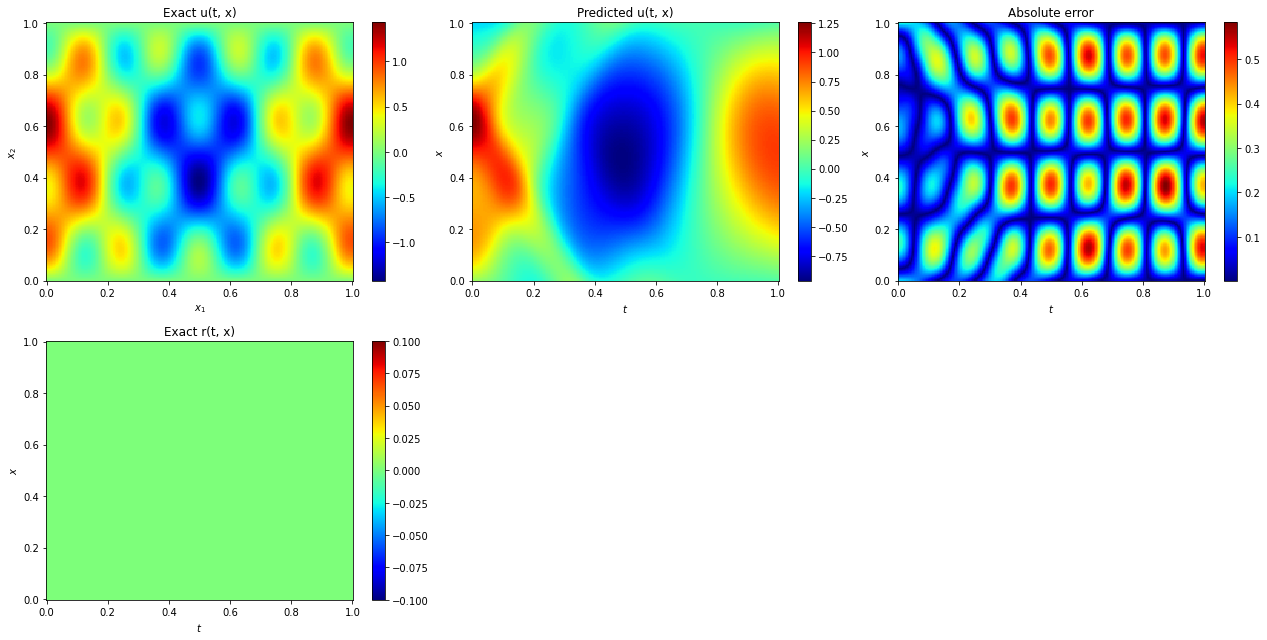

In [8]:
U_star = griddata(X_star, u_exact1.flatten(), (t_star1, x_star1), method='cubic')
p_exact1 = griddata(X_star, p_exact1.flatten(), (t_star1, x_star1), method='cubic')
U_pred = griddata(X_star, v_exact1.flatten(), (t_star1, x_star1), method='cubic')
# R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t_star1, x_star1, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t_star1, x_star1, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t_star1, x_star1, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t_star1, x_star1, p_exact1, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

# plt.subplot(2, 3, 5)
# plt.pcolor(t, x, R_pred, cmap='jet')
# plt.colorbar()
# plt.xlabel('$t$')
# plt.ylabel('$x$')
# plt.title('Predicted r(t, x)')
# plt.tight_layout()

# plt.subplot(2, 3, 6)
# plt.pcolor(t, x, np.abs(r_star - R_pred), cmap='jet')
# plt.colorbar()
# plt.xlabel('$t$')
# plt.ylabel('$x$')
# plt.title('Absolute error')
# plt.tight_layout()
# plt.show()

**NTK Eigenvalues**

In [ ]:
# Create empty lists for storing the eigenvalues of NTK
lam_K_u_log = []
lam_K_ut_log = []
lam_K_r_log = []

# Restore the NTK
K_u_list = model.K_u_log
K_ut_list = model.K_ut_log
K_r_list = model.K_r_log

K_list = []
    
for k in range(len(K_u_list)):
    K_u = K_u_list[k]
    K_ut = K_ut_list[k]
    K_r = K_r_list[k]
    
    # Compute eigenvalues
    lam_K_u, _ = np.linalg.eig(K_u)
    lam_K_ut, _ = np.linalg.eig(K_ut)
    lam_K_r, _ = np.linalg.eig(K_r)
    # Sort in descresing order
    lam_K_u = np.sort(np.real(lam_K_u))[::-1]
    lam_K_ut = np.sort(np.real(lam_K_ut))[::-1]
    lam_K_r = np.sort(np.real(lam_K_r))[::-1]
    
    # Store eigenvalues
    lam_K_u_log.append(lam_K_u)
    lam_K_ut_log.append(lam_K_ut)
    lam_K_r_log.append(lam_K_r)

In [ ]:
#  Eigenvalues of NTK
fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)

plt.plot(lam_K_u_log[0], label = '$n=0$')
plt.plot(lam_K_u_log[1], '--', label = '$n=10,000$')
plt.plot(lam_K_u_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_u_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')

plt.title(r'Eigenvalues of ${K}_u$')

plt.subplot(1,3,2)
plt.plot(lam_K_ut_log[0], label = '$n=0$')
plt.plot(lam_K_ut_log[1], '--',label = '$n=10,000$')
plt.plot(lam_K_ut_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_ut_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{u_t}$')

ax =plt.subplot(1,3,3)
plt.plot(lam_K_r_log[0], label = '$n=0$')
plt.plot(lam_K_r_log[1], '--', label = '$n=10,000$')
plt.plot(lam_K_r_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_r_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{r}$')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.35, -0.02),
            borderaxespad=0, bbox_transform=fig.transFigure, ncol=4)
plt.tight_layout()
plt.show()

**Evolution of NTK Weights**

In [ ]:
if update_lam == True:

  lam_u_log = model.lam_u_log
  lam_ut_log = model.lam_ut_log
  lam_r_log = model.lam_r_log

In [ ]:
fig = plt.figure(figsize=(6, 5))
plt.plot(lam_u_log, label='$\lambda_u$')
plt.plot(lam_ut_log, label='$\lambda_{u_t}$')
plt.plot(lam_r_log, label='$\lambda_{r}$')
plt.xlabel('iterations')
plt.ylabel('$\lambda$')
plt.yscale('log')
plt.legend( )
plt.tight_layout()
plt.show()